In [0]:
import pandas as pd

In [0]:
import numpy as np

In [3]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 3.6MB/s 


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,sent_tokenize
from gensim import corpora
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt


##Loading the data
Converting multi-class data to a binary class data. We want to know when a tweet is hate-speech or not, we merge the other two classes since offensive content isn't always hate speech. The report elaborates more upon the choice of classes.

In [0]:
df_train = pd.read_csv("/content/labeled_data.csv")[["tweet","class"]]

df_train.loc[df_train['class'] == 2, 'class'] = 1

In [6]:
df_train.head()


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,1
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


##Taking equal data points of all classes


In [7]:
X_train = df_train[df_train['class']==0]["tweet"]
X__train = df_train[df_train['class']==1]["tweet"][:1000]
X_train = X_train.append(X__train)
y_train = df_train[df_train['class']==0]["class"]
y_train = y_train.append(df_train[df_train['class']==1]["class"][:1000])

len(X_train)

2430

In [8]:
len(y_train)

2430

##Baseline model
We choose a simple straight forward Count vector based regression model to establish a baseline


In [9]:
pipe  =  make_pipeline(CountVectorizer(),LogisticRegression(solver="sag"))
print("Cross val score on baseline model")
pipe.fit(X_train,y_train)
print(np.mean(cross_val_score(pipe,X_train,y_train,cv=5,scoring="roc_auc")))

Cross val score on baseline model


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8547849650349649


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##Re-implementing the paper

In this part, we follow the steps mentioned in the paper about how to replicate the paper. 

1. Lowercase
2. Stem
3. bigram, unigram, trigram features, weighted by its tfidf
4. POS tag
5. FK Grade level
6. FK reading ease score
7. sentiment scores

8. binary indicators for: hashtags, mentions, retweets, urls
9. count indicatiors for :hashtags, mentions, retweets, urls
10. number of characters
11. numbers of words
12. number of syllables



In [10]:
nltk.download("stopwords")
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt","RT"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    
    #Lowercase string
    text_string=text_string.lower()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    #Stem it
    tweet = " ".join(re.split("[^a-zA-Z]*", parsed_text)).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
  
  
def pos_tag_seq(tokens):
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    return tag_str
  
  

In [0]:
def join_sent(l):
  return " ".join(l)

In [0]:
df_train=pd.DataFrame(X_train)

In [0]:
df_train.columns=["tweet"]

In [15]:
df_train.head()

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [16]:
s_train=df_train['tweet'].apply(preprocess)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
s_tr=s_train.apply(join_sent)

In [18]:
nltk.download('averaged_perceptron_tagger')
t_tr=s_train.apply(pos_tag_seq)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
vectorizer = TfidfVectorizer(
    preprocessor=None,
    lowercase=False,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    stop_words=stopwords,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [0]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [0]:
tfidf_tr = vectorizer.fit_transform(s_tr).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [0]:
pos_tr = pos_vectorizer.fit_transform(t_tr).toarray()

pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()


In [0]:
def get_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  return sentiment

#   return sentiment["neg"], sentiment["pos"], sentiment["neu"]

In [0]:
df_train["sent"]=df_train["tweet"].apply(get_sentiment) 

In [26]:
df_train.head()

,tweet,sent
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...","{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...","{'neg': 0.254, 'neu': 0.746, 'pos': 0.0, 'comp..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http...","{'neg': 0.232, 'neu': 0.488, 'pos': 0.28, 'com..."


In [0]:
foo_tr = lambda x: pd.Series([x["pos"],x["neg"],x["neu"]])
rev_tr = df_train['sent'].apply(foo_tr)


In [0]:
rev_tr.columns=["pos","neg","neu"]

In [29]:
rev_tr.head()

,pos,neg,neu
85,0.00,0.000,1.000
89,0.00,0.187,0.813
110,0.00,0.000,1.000
184,0.00,0.254,0.746
202,0.28,0.232,0.488


##Binary count for URL https mentions etc 

In [0]:
def return_cont(parsed_text):
  return(parsed_text.count('urlher'),parsed_text.count('mentionher'),parsed_text.count('hashtagher'))

In [0]:
df_train["counts"]=s_tr.apply(return_cont) 

In [32]:
df_train["counts"].head()

85     (0, 3, 0)
89     (0, 2, 0)
110    (1, 2, 1)
184    (1, 1, 0)
202    (1, 1, 0)
Name: counts, dtype: object

In [0]:
foo = lambda x: pd.Series([x[0],x[1],x[2]])
mention_counts_tr = df_train['counts'].apply(foo)


In [34]:
mention_counts_tr.head()

,0,1,2
85,0,3,0
89,0,2,0
110,1,2,1
184,1,1,0
202,1,1,0


##FKRA and Flesch and number of syllables etc

In [35]:
!pip install textstat
from textstat.textstat import *

     |████████████████████████████████| 3.0MB 5.0MB/s 


In [0]:
def get_other_features(text):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    words = re.sub(mention_regex, '', parsed_text)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_terms, num_words,
                num_unique_terms]
    return features
    
  

In [0]:
other_feats_tr=df_train["tweet"].apply(get_other_features)

In [38]:
other_feats_tr.head()

85         [9.2, 34.62, 6, 1.9997, 18, 5, 3, 3]
89        [6.8, 67.76, 18, 1.5, 59, 13, 12, 10]
110    [9.1, 49.55, 19, 1.7272, 76, 13, 11, 11]
184    [5.2, 84.46, 19, 1.2666, 78, 15, 15, 15]
202        [2.3, 94.3, 11, 1.2222, 38, 9, 9, 9]
Name: tweet, dtype: object

In [0]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars","num_terms", "num_words", "num_unique_words"]

In [0]:
foo = lambda x: pd.Series(elem for elem in x)
of_counts_tr = other_feats_tr.apply(foo)

In [41]:
of_counts_tr.head()

,0,1,2,3,4,5,6,7
85,9.2,34.62,6.0,1.9997,18.0,5.0,3.0,3.0
89,6.8,67.76,18.0,1.5000,59.0,13.0,12.0,10.0
110,9.1,49.55,19.0,1.7272,76.0,13.0,11.0,11.0
184,5.2,84.46,19.0,1.2666,78.0,15.0,15.0,15.0
202,2.3,94.30,11.0,1.2222,38.0,9.0,9.0,9.0


In [0]:
of_counts_tr.columns=other_features_names

In [43]:
of_counts_tr.head()

,FKRA,FRE,num_syllables,avg_syl_per_word,num_chars,num_terms,num_words,num_unique_words
85,9.2,34.62,6.0,1.9997,18.0,5.0,3.0,3.0
89,6.8,67.76,18.0,1.5000,59.0,13.0,12.0,10.0
110,9.1,49.55,19.0,1.7272,76.0,13.0,11.0,11.0
184,5.2,84.46,19.0,1.2666,78.0,15.0,15.0,15.0
202,2.3,94.30,11.0,1.2222,38.0,9.0,9.0,9.0


In [44]:
#Removing unnecessary columns
df_train.drop([ "sent","counts"], axis=1)

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
204,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna..."
219,"""@RTNBA: Drakes new shoes that will be release..."
260,"""@TheoMaxximus: #GerrysHalloweenParty http://t..."
312,"""@ashlingwilde: @ItsNotAdam is bored supposed ..."
315,"""@bigbootybishopp: @white_thunduh lassen cc , ..."


In [45]:
#Confirming all dataframes have the same length
for elem in [pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr]:
  print(len(elem))


2430
2430
2430
2430
2430


In [0]:
#Forming the final training dataset using the features
x_train=np.concatenate([pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr],axis=1 )
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)


In [47]:
print(len(x_train), len(y_train))

1944 1944


In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline


We run a grid search on SVC and LogisticRegression using various parameters.  

In [50]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2,0.01, 10,100],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.1,0.01, 1, 10, 100]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classificatio

Best parameters set found on development set:

{'C': 0.01, 'kernel': 'linear'}

Grid scores on development set:

0.664 (+/-0.103) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.664 (+/-0.103) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.294 (+/-0.001) for {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.672 (+/-0.101) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.294 (+/-

In [0]:
scores = ['precision', 'recall']
penalty = ['l1', 'l2']

logistic = LogisticRegression()

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(logistic, hyperparameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


## Chosing a model

From the given models, we choose using an SVC with the parameters
'C': 0.01, 'kernel': 'linear'
This is because given the task of detecting hate speech requires that we maximize the amount of hate speech recognized from actual hate speech there exists. The cost of not recognizing hate speech is higher than the cost of recognizing false positives. Hence given a trade off, we chose to look for higher recall and hence settled on SVC model.
The authors also did a similar thing.

In [0]:
model=SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True)
model.fit(x_train,y_train)
y_preds=model.predict(x_train)
report = classification_report( y_preds, y_train )

## Evaluating Model Performance



**This section is divided into the following major parts :**
- In-sample predictive performance
- Out-of-sample predictive performance
- Effects of statistical significance on Predictive Power

Detailed explanations of the above parts follow.

### In-Sample Predictive Performance

We are interested in the training accuracy here, in other words the model is tested on data sampled from within the training set.

Logistic Regression is used here to obtain the best performing features using the "SelectFromModel" function and the Linear SVC model is trained and tested for performance.

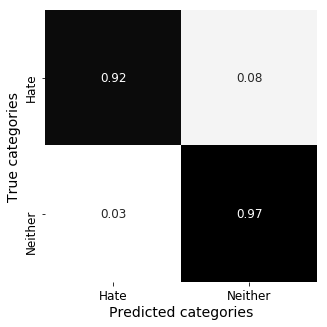

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix = confusion_matrix(y_train,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


                 A            B
count  1944.000000  1944.000000
mean      0.412037     0.441872
std       0.492328     0.496737
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     1.000000
max       1.000000     1.000000


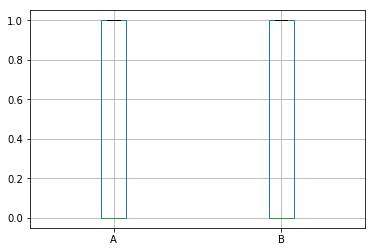

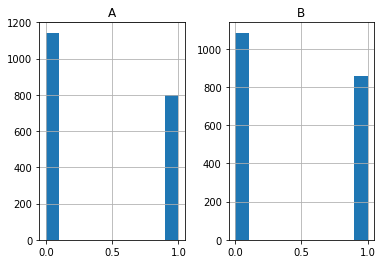

In [53]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load results file
results = pd.DataFrame()
results['A'] = y_train
results['B'] = y_preds
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()
# histogram
results.hist()
pyplot.show()

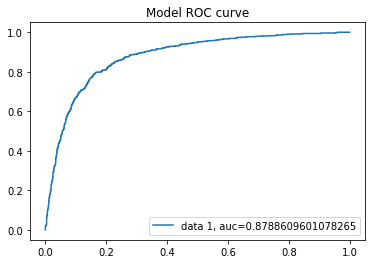

In [54]:
clf = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf.fit(x_train,y_train)

# {'C': 0.01, 'kernel': 'linear'}
proba = cross_val_predict(clf, x_train,y_train, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_train,  proba[::,1])
auc = metrics.roc_auc_score(y_train, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Model ROC curve')
plt.show()

The ROC curve shows promising results, and an AUC of 0.87 was obtained. To give context, a model that randomly guessed the class (50-50 chance) would give a straight line ROC curve with an AUC of 0.5. The model performs significantly better.

We will now investigate the these metrics (precision, recall and f1-scores) at the various threshold values ranging from 0 to 1.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


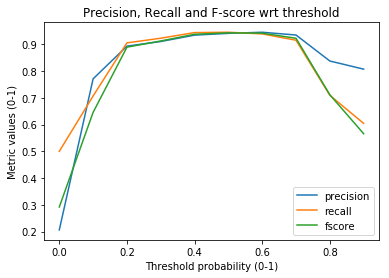

In [55]:
from sklearn.metrics import precision_recall_fscore_support as score

thresh_range = list(np.arange(0,1,0.1))
p_list = list()
r_list = list()
f_list = list()
for threshold in thresh_range:
    y_preds = np.where(model.predict_proba(x_train)[:,1] > threshold, 1, 0)
    precision,recall,fscore,support=score(y_train,y_preds,average='macro')
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(fscore)
plt.plot(thresh_range,p_list,label='precision')
plt.plot(thresh_range,r_list,label='recall')
plt.plot(thresh_range,f_list,label='fscore')
plt.xlabel('Threshold probability (0-1)')
plt.ylabel('Metric values (0-1)')
plt.title('Precision, Recall and F-score wrt threshold')
plt.legend()


The above curves demonstrate the best threshold values for our metrics. For this model we obtain an optimum threshold in the (0.4,0.6) range as seen from the above plot. The precision and recall tend to follow very similar trends. Would be interesting to see the precision vs recall curve.

Text(0, 0.5, 'Precision (0-1)')

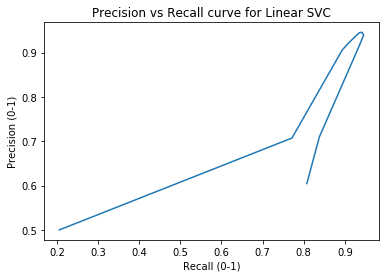

In [56]:
plt.plot(p_list,r_list)
plt.title('Precision vs Recall curve for Linear SVC')
plt.xlabel('Recall (0-1)')
plt.ylabel('Precision (0-1)')


Interesting many-one, non-bijective curve. Both metrics peak at the same time, and at a little less than 1.

This concludes the In-sample performance evaluation. Now we will use a test dataset that isn't in-sample and see the difference in results.

### Out-of-sample Predictive Performance

Here we use new unseen data to test our model. We expect a decline in performance, but this will also give us a peak into how generalizable the proposed Linear SVC model is.

In [0]:
# model2 = SVC(kernel='linear',class_weight='balanced',C=0.01,probability=True).fit(x_train, y_train)
# model2=SVC(class_weight='balanced',C=0.01, kernel='rbf',probability=True).fit(x_train, y_train)
y_preds = model.predict(x_test)
report = classification_report( y_test, y_preds )

In [58]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       287
           1       0.78      0.82      0.80       199

   micro avg       0.83      0.83      0.83       486
   macro avg       0.82      0.83      0.83       486
weighted avg       0.83      0.83      0.83       486



There is a 0.08 reduction across the weighted score of the three metrics. The values drop from 0.93 to 0.82. This was expected, and the ~10% reduction in the scores on unseen data shows that the model is generalizable and wasn't overfitting the training data.

Let us now plot the roc curve for the out-sample case and compare it to our previous in-sample performance. One would expect a minor decline in AUC, which would be in line with the marginal performance metric decline we have seen above.

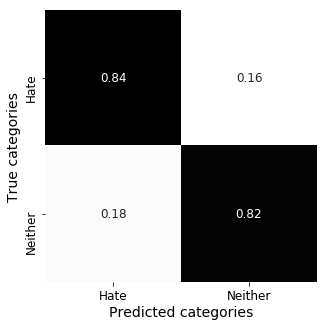

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


                A           B
count  486.000000  486.000000
mean     0.409465    0.434156
std      0.492242    0.496156
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      1.000000    1.000000
max      1.000000    1.000000


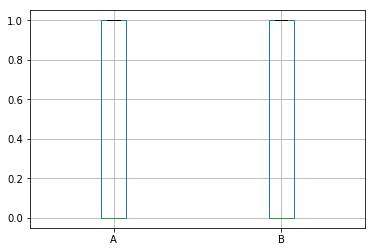

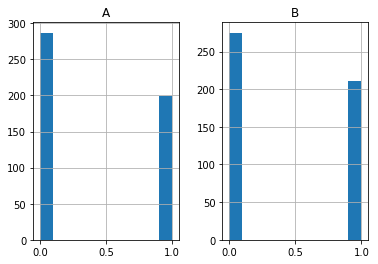

In [60]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load results file
results = pd.DataFrame()
results['A'] = y_test
results['B'] = y_preds
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()
# histogram
results.hist()
pyplot.show()

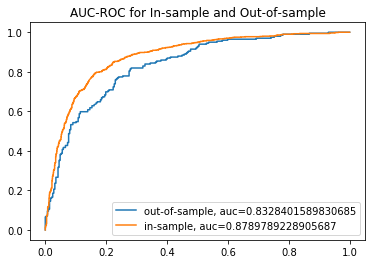

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

clf = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf.fit(x_train,y_train)

proba = cross_val_predict(clf, x_test,y_test, cv=5, method='predict_proba')
probb = cross_val_predict(clf, x_train,y_train, cv=5, method='predict_proba')
from sklearn import metrics

fpra, tpra, _ = metrics.roc_curve(y_test,  proba[::,1])
auca = metrics.roc_auc_score(y_test, proba[::,1])
fprb, tprb, _ = metrics.roc_curve(y_train,  probb[::,1])
aucb = metrics.roc_auc_score(y_train, probb[::,1])

plt.plot(fpra,tpra,label="out-of-sample, auc="+str(auca))
plt.plot(fprb,tprb,label="in-sample, auc="+str(aucb))

plt.legend(loc=4)
plt.title('AUC-ROC for In-sample and Out-of-sample')
plt.show()

The AUC falls from 0.87 for in-sample to 0.82 for out-of-sample. The difference is clear from the ROC curves.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


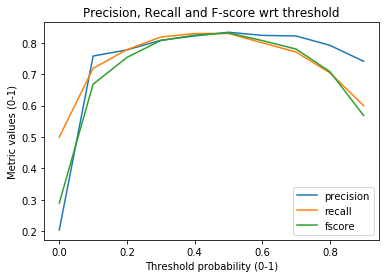

In [62]:
from sklearn.metrics import precision_recall_fscore_support as score

thresh_range = list(np.arange(0,1,0.1))
p_list = list()
r_list = list()
f_list = list()
for threshold in thresh_range:
    y_preds = np.where(model.predict_proba(x_test)[:,1] > threshold, 1, 0)
    precision,recall,fscore,support=score(y_test,y_preds,average='macro')
    p_list.append(precision)
    r_list.append(recall)
    f_list.append(fscore)
plt.plot(thresh_range,p_list,label='precision')
plt.plot(thresh_range,r_list,label='recall')
plt.plot(thresh_range,f_list,label='fscore')

plt.xlabel('Threshold probability (0-1)')
plt.ylabel('Metric values (0-1)')
plt.title('Precision, Recall and F-score wrt threshold')
plt.legend()


We see a similar plot as in-sample, though the maxima seems to have shifted to a lower threshold.

The precision and recall tend to follow very similar trends. Would be interesting to see the precision vs recall curve.

Text(0, 0.5, 'Precision (0-1)')

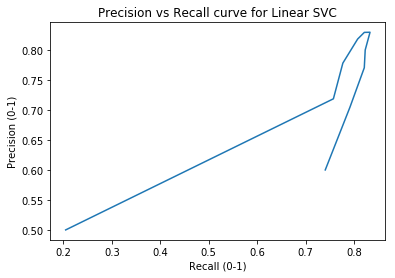

In [63]:
plt.plot(p_list,r_list)
plt.title('Precision vs Recall curve for Linear SVC')
plt.xlabel('Recall (0-1)')
plt.ylabel('Precision (0-1)')


As before, many-one, non-bijective curve. Both metrics peak at around the same time, with two marked differences from the corresponding in-sample plot.
 - The maximum observed for out-sample is of lower value than in-sample.
 
 - While they do peak around the same time, the spread is more (i.e both don't peak at exactly the same time as was the case with in-sample, rather the peak shows a greater spread as seen above).

This concludes the out-of-sample performance evaluation. Now we will use a test dataset that isn't in-sample and see the difference in results.



### Effects of Statistical Significance on Predictive Power

The following section investigates the effect of statistical significance of a variable on its prediction power. On second thought, 'Effect' might not be the appropriate term here, since that implies causation. Let us investigate the correlation of statistical significance of features with their predictive powers.

This is achieved by implementing a 'backward elimination' function, that assumes all features are significant and the eliminates those that are found to have p-values higher than 5% Level of significance.

An issue encountered was the painfully slow runtime, so we take a short-cut here. Let us select 500 features at random (of the 2303 total features). Empricial evidence during the course of this project suggests that we get back less than 10% of the features we created on this dataset.

We apply the backward elimination function to obtained a reduced feature set. The the model constructed on the 500 features, and another one constructed on the stat-significant feature subset obtained are evaluated.

In [0]:
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl,columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x,columns
SL = 0.05

In [0]:
from random import sample 
  
# Prints list of random items of given length 
tot_features = list(range(2033))
subset = sample(tot_features,500)
dm,col = backwardElimination(x_train[:,subset], y_train, SL,np.arange(500))

In [66]:
print('The number of statistically significant features from the 500 : ',len(col))

The number of statistically significant features from the 500 :  81


In [0]:
model = SVC(kernel='linear',class_weight='balanced',C=0.01,probability=True).fit(x_train, y_train)

y_preds = model.predict(x_test)
report = classification_report( y_test, y_preds )

In [68]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       287
           1       0.78      0.82      0.80       199

   micro avg       0.83      0.83      0.83       486
   macro avg       0.82      0.83      0.83       486
weighted avg       0.83      0.83      0.83       486



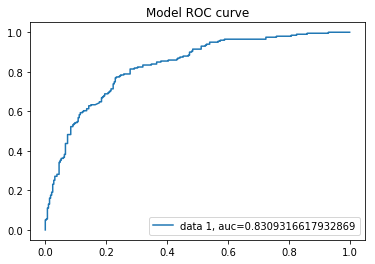

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

clf = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf.fit(x_train,y_train)

proba = cross_val_predict(clf, x_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Model ROC curve')
plt.show()

The above analysis has been performed for the data with 500 randomly selected features. 

We can see that it gives us a reasonable 0.84 AUC value and the precision,recall and f1 are 0.82.

It would now be interesting to compare this to the results for a model that takes just the statistically significant features from these 500. We saw that 68 features qualified with p-values less than the 5% level of significance.

In [0]:
model = SVC(kernel='linear',class_weight='balanced',C=0.01,probability=True).fit(x_train[:,col], y_train)

y_preds = model.predict(x_test[:,col])
report = classification_report( y_test, y_preds )

In [71]:
print(report)

              precision    recall  f1-score   support

           0       0.67      0.87      0.76       287
           1       0.67      0.39      0.50       199

   micro avg       0.67      0.67      0.67       486
   macro avg       0.67      0.63      0.63       486
weighted avg       0.67      0.67      0.65       486



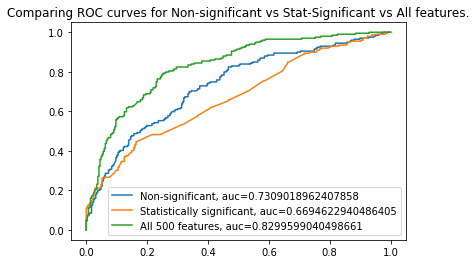

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

clf1 = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf1.fit(x_train[:,~col],y_train)

clf2 = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf2.fit(x_train[:,col],y_train)

clf3 = Pipeline(steps=[('classifier', SVC(class_weight='balanced',C=0.01, kernel='linear',probability=True))])
clf3.fit(x_train,y_train)



proba = cross_val_predict(clf1, x_test[:,~col],y_test, cv=5, method='predict_proba')
probb = cross_val_predict(clf2, x_test[:,col],y_test, cv=5, method='predict_proba')
probc = cross_val_predict(clf3, x_test,y_test, cv=5, method='predict_proba')

from sklearn import metrics

fpra, tpra, _ = metrics.roc_curve(y_test,  proba[::,1])
auca = metrics.roc_auc_score(y_test, proba[::,1])

fprb, tprb, _ = metrics.roc_curve(y_test,  probb[::,1])
aucb = metrics.roc_auc_score(y_test, probb[::,1])

fprc, tprc, _ = metrics.roc_curve(y_test,  probc[::,1])
aucc = metrics.roc_auc_score(y_test, probc[::,1])

plt.plot(fpra,tpra,label="Non-significant, auc="+str(auca))
plt.plot(fprb,tprb,label="Statistically significant, auc="+str(aucb))
plt.plot(fprc,tprc,label="All 500 features, auc="+str(aucc))

plt.legend(loc=4)
plt.title('Comparing ROC curves for Non-significant vs Stat-Significant vs All features.')
plt.show()

This is an interesting result, the performance for just the statistically significant features (68 in number) is 0.62, which is better than the 0.45 AUC result for the non-significant features (432 in number). Infact random guessing would give better results than the model trained on just the non-significant features.

The result taking all 500 features is the best performer by a margin. Model using the significant features alone is clearly overfitting.